# UQ of mean fields

In this notebook we show how one can use multiple batches of averages fields to perform a UQ analysis.

For this case we assume that you have a set of files already. The visualizations here rely on you having an structured mesh

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

# Hide the log for the notebook. Not recommended when running in clusters as it is better you see what happens
import os
os.environ["PYNEKTOOLS_HIDE_LOG"] = 'true'


### Define inputs

In [2]:
query_points_fname = "./points.hdf5" # In our case this file contains the mesh and the mass matrix
file_sequence = [f"mean_field{str(i+1).zfill(5)}.hdf5" for i in range(0, 10)]

## Visualize the data in the cylindrical mesh

 We can now load the data and check it out.

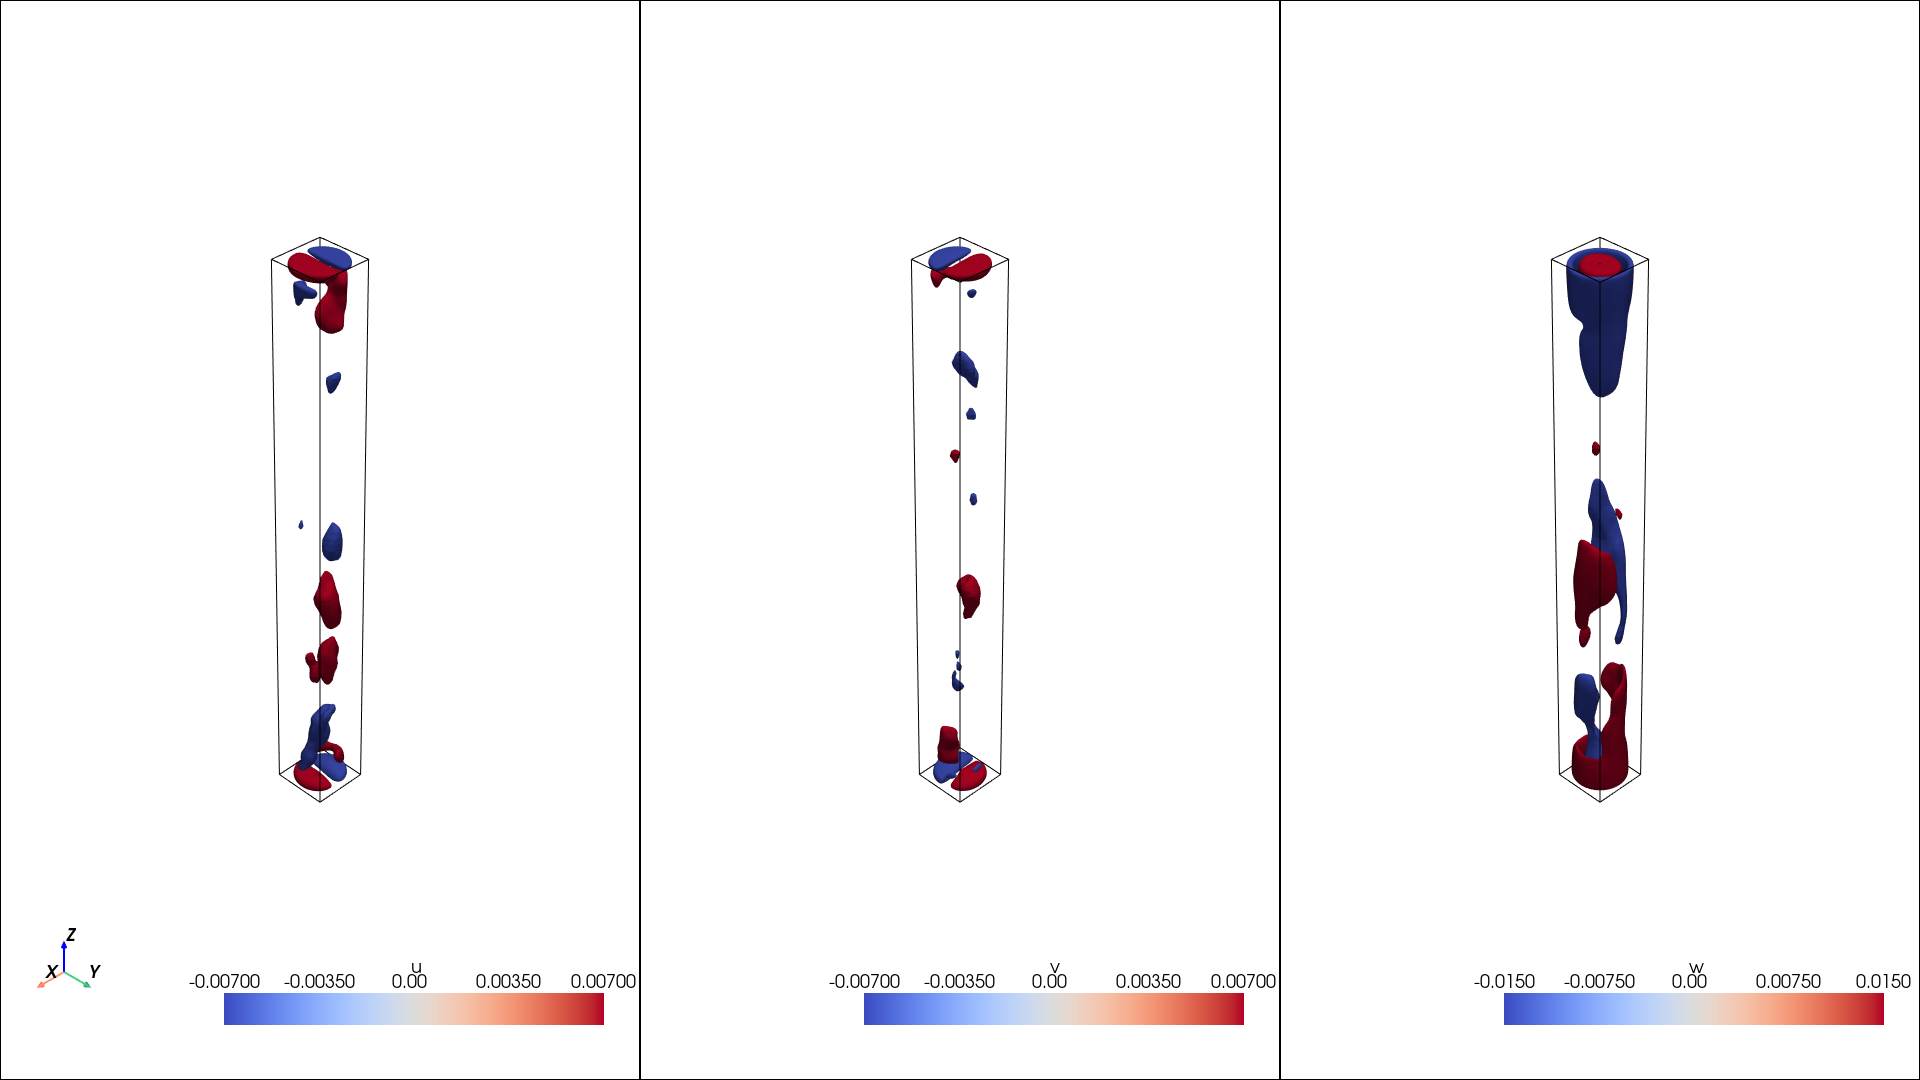

In [3]:
from pynektools.postprocessing.statistics.uq import NOBM

mean, var = NOBM(comm, file_sequence, ["u", "v", "w"])

import h5py
import pyvista as pv
from IPython.display import Image, display

# Load the mesh
with h5py.File(query_points_fname, 'r') as f:
    x = f["x"][:]
    y = f["y"][:]
    z = f["z"][:]

# Create a structured mesh
mesh_1 = pv.StructuredGrid(x, y, z)
mesh_1.point_data["u"] = mean["u"].ravel(order='F')
mesh_1.point_data["v"] = mean["v"].ravel(order='F')
mesh_1.point_data["w"] = mean["w"].ravel(order='F')

# Plot
pl = pv.Plotter(shape=(1, 3), window_size=[1920,1080]) # Size in pixels
pl.add_axes() 
# plot first row
pl.subplot(0, 0)
isos = mesh_1.contour(scalars = "u", isosurfaces = [-0.007, 0.007])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

pl.subplot(0, 1)
isos = mesh_1.contour(scalars = "v", isosurfaces = [-0.007, 0.007])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

pl.subplot(0, 2)
isos = mesh_1.contour(scalars = "w", isosurfaces = [-0.015, 0.015])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

#pl.show()

# Capture the plot as an image and show it
image_path = f"static_plot_SME.png"
pl.screenshot(image_path)
pl.close()
display(Image(filename=image_path))

## field keys

The interpolated fields and also the fields read from nek5000 have a set of given keys. One could know what each of the keys represent by heart, but we have also provided some "indices" to help identify what is what.

It can be used as folows:

In [4]:
from pynektools.postprocessing.statistics.file_field_index import file_field_index

# Specify the source of the data
key_index = file_field_index(source_code="Neko_old") # Neko old alludes to statistics written between 2 files
print(key_index["U"]["pynek_field_key"])

u


In [5]:
from pynektools.postprocessing.rotations import rotate_tensor
from pynektools.postprocessing.rotations import cartesian_to_cylindrical_rotation_matrix as rotation_matrix


rot_tensor = rotate_tensor([x, y, z], [u_SME, v_SME, w_SME], ["U", "V", "W"], rotation_matrix, output_field_names=["U_r", "U_th", "U_z"])

u = rot_tensor[0]
v = rot_tensor[1]
w = rot_tensor[2]

# Create a structured mesh
mesh_1 = pv.StructuredGrid(x, y, z)
mesh_1.point_data["u"] = u.ravel(order='F')
mesh_1.point_data["v"] = v.ravel(order='F')
mesh_1.point_data["w"] = w.ravel(order='F')

# Plot
pl = pv.Plotter(shape=(1, 3), window_size=[1920,1080]) # Size in pixels
pl.add_axes() 
# plot first row
pl.subplot(0, 0)
isos = mesh_1.contour(scalars = "u", isosurfaces = [-0.007, 0.007])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

pl.subplot(0, 1)
isos = mesh_1.contour(scalars = "v", isosurfaces = [-0.007, 0.007])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

pl.subplot(0, 2)
isos = mesh_1.contour(scalars = "w", isosurfaces = [-0.015, 0.015])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

#pl.show()

# Capture the plot as an image and show it
image_path = "static_plot.png"
pl.screenshot(image_path)
pl.close()
display(Image(filename=image_path))


NameError: name 'u_SME' is not defined

see that printing the field_key of U gives 

## Rotate the data to cylindrical coordinates

In this instance, it is beneficial to rotate the data given the shape of our domain

Some of the terms that we have in our files are tensors and require special treatment. However we will rotate only some of the quantities.

Here we will go through the tensors and apply rotations depending on what is needed since the rotation must be applied differently depending on the rank of the tensor.

The user must provide a rotation matrix fuction that generates a rotation matrix given the coordinates. For this case, we can use one included in pynektools, since this is simply a cylinder.

The tensor_components list should contain the keys to be used to identify the tensor components in the file.

In [6]:
from pynektools.postprocessing.rotations import cartesian_to_cylindrical_rotation_matrix as rotation_matrix
from pynektools.postprocessing.rotations import rotate_tensor
import os

# Specify the components of the tensor. This should match the key in the file
for i, fname in enumerate(file_sequence):
    tensor_components = [key_index["U"]["pynek_field_key"], key_index["V"]["pynek_field_key"], key_index["W"]["pynek_field_key"]]
    prefix = os.path.basename(fname).split(".")[0]
    rotate_tensor(query_points_fname, fname, tensor_components, rotation_matrix, output_file=f"rotated_{prefix}.hdf5", output_field_names=["U_r", "U_th", "U_z"])

# Visualize the rotated mean

Now check out how the rotated quantities look

In [ ]:
# Load the mesh
with h5py.File(query_points_fname, 'r') as f:
    x = f["x"][:]
    y = f["y"][:]
    z = f["z"][:]

# Load the interpolated data
with h5py.File("./rotated_mean_fields.hdf5", 'r') as f:
    u = f["U_r"][:]
    v = f["U_th"][:]
    w = f["U_z"][:]

# Create a structured mesh
mesh_1 = pv.StructuredGrid(x, y, z)
mesh_1.point_data["u"] = u.ravel(order='F')
mesh_1.point_data["v"] = v.ravel(order='F')
mesh_1.point_data["w"] = w.ravel(order='F')

# Plot
pl = pv.Plotter(shape=(1, 3), window_size=[1920,1080]) # Size in pixels
pl.add_axes() 
# plot first row
pl.subplot(0, 0)
isos = mesh_1.contour(scalars = "u", isosurfaces = [-0.007, 0.007])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

pl.subplot(0, 1)
isos = mesh_1.contour(scalars = "v", isosurfaces = [-0.007, 0.007])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

pl.subplot(0, 2)
isos = mesh_1.contour(scalars = "w", isosurfaces = [-0.015, 0.015])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

#pl.show()

# Capture the plot as an image and show it
image_path = "static_plot.png"
pl.screenshot(image_path)
pl.close()
display(Image(filename=image_path))

In [ ]:
nsamples = 0
u_SME = np.zeros_like(x)
v_SME = np.zeros_like(y)
w_SME = np.zeros_like(z)
for i, fname in enumerate(file_sequence):
    # Load the interpolated data
    with h5py.File(f"rotated_{fname}", 'r') as f:
        u = f["U_r"][:]
        v = f["U_th"][:]
        w = f["U_z"][:]
    
    nsamples += 1
    u_SME += u
    v_SME += v
    w_SME += w

    # Create a structured mesh
    mesh_1 = pv.StructuredGrid(x, y, z)
    mesh_1.point_data["u"] = u.ravel(order='F')
    mesh_1.point_data["v"] = v.ravel(order='F')
    mesh_1.point_data["w"] = w.ravel(order='F')

    # Plot
    pl = pv.Plotter(shape=(1, 3), window_size=[1920,1080]) # Size in pixels
    pl.add_axes() 
    # plot first row
    pl.subplot(0, 0)
    isos = mesh_1.contour(scalars = "u", isosurfaces = [-0.007, 0.007])
    pl.add_mesh(mesh_1.outline(), color="k")
    pl.add_mesh(isos, opacity=1, cmap="coolwarm")

    pl.subplot(0, 1)
    isos = mesh_1.contour(scalars = "v", isosurfaces = [-0.007, 0.007])
    pl.add_mesh(mesh_1.outline(), color="k")
    pl.add_mesh(isos, opacity=1, cmap="coolwarm")

    pl.subplot(0, 2)
    isos = mesh_1.contour(scalars = "w", isosurfaces = [-0.015, 0.015])
    pl.add_mesh(mesh_1.outline(), color="k")
    pl.add_mesh(isos, opacity=1, cmap="coolwarm")

    #pl.show()

    # Capture the plot as an image and show it
    image_path = f"static_plot_{i+1}.png"
    pl.screenshot(image_path)
    pl.close()
    display(Image(filename=image_path))

u_SME /= nsamples
v_SME /= nsamples
w_SME /= nsamples

# Create a structured mesh
mesh_1 = pv.StructuredGrid(x, y, z)
mesh_1.point_data["u"] = u_SME.ravel(order='F')
mesh_1.point_data["v"] = v_SME.ravel(order='F')
mesh_1.point_data["w"] = w_SME.ravel(order='F')

# Plot
pl = pv.Plotter(shape=(1, 3), window_size=[1920,1080]) # Size in pixels
pl.add_axes() 
# plot first row
pl.subplot(0, 0)
isos = mesh_1.contour(scalars = "u", isosurfaces = [-0.007, 0.007])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

pl.subplot(0, 1)
isos = mesh_1.contour(scalars = "v", isosurfaces = [-0.007, 0.007])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

pl.subplot(0, 2)
isos = mesh_1.contour(scalars = "w", isosurfaces = [-0.015, 0.015])
pl.add_mesh(mesh_1.outline(), color="k")
pl.add_mesh(isos, opacity=1, cmap="coolwarm")

#pl.show()

# Capture the plot as an image and show it
image_path = f"static_plot_SME.png"
pl.screenshot(image_path)
pl.close()
display(Image(filename=image_path))

with h5py.File("rotated_mean_fields.hdf5", 'w') as f:
    f.create_dataset(f"U_r", data=u_SME)
    f.create_dataset(f"U_th", data=v_SME)
    f.create_dataset(f"U_z", data=w_SME)


## Perform 2d plots

In this case, we can average in the azimuthal direction.

In [ ]:
# Load mass matrix
with h5py.File(query_points_fname, 'r') as f:
    bm = f["mass"][:]
bm[np.where(bm == 0)] = 1e-12

# Load the mesh
with h5py.File(query_points_fname, 'r') as f:
    r = f["r"][:]
    th = f["th"][:]
    z = f["z"][:]


# Load the interpolated data
with h5py.File("./rotated_mean_fields.hdf5", 'r') as f:
    u = f["U_r"][:]
    v = f["U_th"][:]
    w = f["U_z"][:]

#Average in the azimuthal direction direction
u_rz = np.sum(u*bm, axis=1)/ np.sum(bm, axis=1)
v_rz = np.sum(v*bm, axis=1)/ np.sum(bm, axis=1)
w_rz = np.sum(w*bm, axis=1)/ np.sum(bm, axis=1)

levels = np.linspace(-0.05, 0.05, 100)

fig, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].tricontourf(r[:,0,:].flatten(),z[:,0,:].flatten(), u_rz.flatten(), levels=levels, cmap="RdBu_r")
ax[1].tricontourf(r[:,0,:].flatten(),z[:,0,:].flatten(), v_rz.flatten(), levels=levels, cmap="RdBu_r")
ax[2].tricontourf(r[:,0,:].flatten(),z[:,0,:].flatten(), w_rz.flatten(), levels=levels, cmap="RdBu_r")
#plt.show()
fig.savefig("contours.png")
plt.close()
display(Image(filename="contours.png"))


## Perform 1D plots

Plot the rotated values in 1d, by averaging in azimuthal and radial directions. In this case, this might not be so telling, as the flow is not homogenous in the radial direction, but it have give an indication on how the flow behaves.

In this case, we might have had too few points close to the wall, as we do not observe any peak in the z velocity component. Note that it would appear better if we take the square root.

In [ ]:
# Load mass matrix
with h5py.File(query_points_fname, 'r') as f:
    bm = f["mass"][:]
bm[np.where(bm == 0)] = 1e-12

# Load the interpolated data
with h5py.File("./rotated_mean_fields.hdf5", 'r') as f:
    u = f["U_r"][:]
    v = f["U_th"][:]
    w = f["U_z"][:]

# Average in the azimuthal direction and radial direction
u_z = np.sum(u*bm, axis=(0,1))/ np.sum(bm, axis=(0,1))
v_z = np.sum(v*bm, axis=(0,1))/ np.sum(bm, axis=(0,1))
w_z = np.sum(w*bm, axis=(0,1))/ np.sum(bm, axis=(0,1))


fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.plot(z[0,0,:], u_z, '-k', label="u_r")
ax.plot(z[0,0,:], v_z, '-b', label="u_th")
ax.plot(z[0,0,:], w_z, '-r', label="u_z")
ax.set_xlabel("z")
fig.legend()
#plt.show()
fig.savefig("mean_fields.png")
plt.close()
display(Image(filename="mean_fields.png"))



In [ ]:
z_1d = z[0,0,:]
print(z_1d[np.where(u_z == np.max(u_z))])
print(1/(2*58.089994))